# RNA-Sequencing


## What we'll be covering today

- Setting up a script to align reads to a genome using **RSEM**
- Gathering some quality metrics on your reads using **PicardTools**
- Creating a list of differentially-expressed genes using **EBSeq**
- Creating some summary plots of your data and differential genes with **Python**
    - Using the **pandas**, **matplotlib**, and **seaborn** libraries
- Calculating **GO** (Gene Ontology) Enrichments
- Viewing alignments with IGV


# Section 1:  Aligning Reads and Quantifying Expression
## What you need to start aligning

A couple of things are needed to arrive at expression values for your samples

### 1. Your read files

Reads typically come in the **fastq** file format

These files will either end in `.fastq` or `.fastq.gz` (more on the 'gz' in a minute)

The format is **4 lines per read** with different information on each line.

(From [Wikipedia](https://en.wikipedia.org/wiki/FASTQ_format))

- Line 1 begins with a '@' character and is followed by a sequence identifier and an optional description (like a FASTA title line).
- Line 2 is the raw sequence letters.
- Line 3 begins with a '+' character and is optionally followed by the same sequence identifier (and any description) again.
- Line 4 encodes the quality values for the sequence in Line 2, and must contain the same number of symbols as letters in the sequence.

Here's what this looks like:

    @SRR2131833.1 HWI-ST218:371:HAVAKADXX:1:1101:1318:2220 length=100
    CTGTAATCCCACTATAGCAATAACCATTATAACTTCGTAGTGTATTTCCTTCCAGTCAACCCGCAGATCTTAGTAATCATAGTTAGGTGA
    +SRR2131833.1 HWI-ST218:371:HAVAKADXX:1:1101:1318:2220 length=100
    CCCFFFFFHHHHHJJJJJJJJJJJJJJJJJJJJJJJJIJJJJJIIJJJJJJJJJJJJJJJJJJJJJIJHHHHHHHFFFFFFFEEEEEEDD
    @SRR2131833.2 HWI-ST218:371:HAVAKADXX:1:1101:2591:2222 length=100
    CTCCAGGTAATAGCCATCAAACTCCACTAAGCCAGACAAAGTGTTATAAATGTTCGAGTTGGGGTGGTTGGTAAGAATATGGTTTTGAGT
    +SRR2131833.2 HWI-ST218:371:HAVAKADXX:1:1101:2591:2222 length=100
    ... and so on

For paired-end data, the reads may come in two files, with the same name, but a \_1 or a \_2 to mark the members of a pair.

     SRR2131833_1.fastq  SRR2131833_2.fastq
     
#### GZIP

Often read files are compressed using a program called 'gzip'

gzip is good at compressing text, and usually read files are compressed for storage and transmission (faster downloading)

A gzip'd file should end with the **.gz** extension (hence, a file like `SRR2131833_1.fastq.gz`)

**How to Unzip**

Just run the command `gunzip`

```
gunzip SRR2131833_1.fastq.gz
```

This uncompresses the file, and replaces it with the unzipped version (same name, but without the .gz)

**How to zip back up**

Just run the `gzip` command

```
gzip SRR2131833_1.fastq
```

This compresses the file, replacing it with the compressed version (same name, now with the .gz added)

Most programs that require a file won't work with the gzipped form.  Some will check and unzip it, but it's not the norm.

### 2. A Genome to map reads onto and an Annotation

#### Genome

Your raw sequence.  Your G's, A's, C's, and T's.

Will come in a **FASTA** file.  Looks like this:

    >1 dna_rm:chromosome chromosome:GRCh38:1:1:248956422:1 REF
    TTTAAACGAGATTGCCAGCACCGGGTATCATTCACCATTTTTCTTTTCGTTAACTTGCCG
    TCAGCCTTTTCTTTGACCTCTTCTTTCTGTTCATGTGTATTTGCTGTCTCTTAGCCCAGA
    CTTCCCGTGTCCTTTCCACCGGGCCTTTGAGAGGTCACAGGGTCTTGATGCTGTGGTCTT
    CATCTGCAGGTGTCTGACTTCCAGCAACTGCTGGCCTGTGCCAGGGTGCAAGCTGAGCAC
    TGGAGTGGAGTTTTCCTGTGGAGAGGAGCCATGCCTAGAGTGGGATGGGCCATTGTTCAT
    CTTCTGGCCCCTGTTGTCTGCATGTAACTTAATACCACAACCAGGCATAGGGGAAAGATT
    GGAGGAAAGATGAGTGAGAGCATCAACTTCTCTCACAACCTAGGCCAGTAAGTAGTGCTT
    GTGCTCATCTCCTTGGCTGTGATACGTGGCCGGCCCTCGCTCCAGCAGCTGGACCCCTAC
    CTGCCGTCTGCTGCCATCGGAGCCCAAAGCCGGGCTGTGACTGCTCAGACCAGCCGGCTG

Each **sequence** begins with a line describing it that starts with a ">"

In this example, the sequence name is just "1" (for chromosome 1).
    - You'll also see it written like "chr1" in other references
    
    
#### Annotation File

The sequence by itself isn't all that useful - we need to know where the genes are!

That's where the annotation file comes in.

Annotation files usually use either the **GTF** or the **GFF3** file formats

They look like this:

    1       havana  gene       11869   14409   .       +       .       gene_id "ENSG00000223972"; gene_...
    1       havana  transcript 11869   14409   .       +       .       gene_id "ENSG00000223972...
    1       havana  exon       11869   12227   .       +       .       gene_id "ENSG00000223972"; gene_...
    1       havana  exon       12613   12721   .       +       .       gene_id "ENSG00000223972"; gene_...
    1       havana  exon       13221   14409   .       +       .       gene_id "ENSG00000223972"; gene_...
    1       havana  transcript 12010   13670   .       +       .       gene_id "ENSG00000223972...
    1       havana  exon       12010   12057   .       +       .       gene_id "ENSG00000223972"; gene_...
    
Each column has (from [Ensemble](http://www.ensembl.org/info/website/upload/gff.html)):

1. **seqname** - name of the chromosome or scaffold; chromosome names can be given with or without the 'chr' prefix. Important note: the seqname must be one used within Ensembl, i.e. a standard chromosome name or an Ensembl identifier such as a scaffold ID, without any additional content such as species or assembly. See the example GFF output below.
2. **source** - name of the program that generated this feature, or the data source (database or project name)
3. **feature** - feature type name, e.g. Gene, Variation, Similarity
4. **start** - Start position of the feature, with sequence numbering starting at 1.
5. **end** - End position of the feature, with sequence numbering starting at 1.
6. **score** - A floating point value.
7. **strand** - defined as + (forward) or - (reverse).
8. **frame** - One of '0', '1' or '2'. '0' indicates that the first base of the feature is the first base of a codon, '1' that the second base is the first base of a codon, and so on..
9. **attribute** - A semicolon-separated list of tag-value pairs, providing additional information about each feature.

    
#### Where can you get them?

- [Ensemble](http://www.ensembl.org/index.html)
- [UCSC Genome Browser](http://hgdownload.soe.ucsc.edu/downloads.html)

\*\***Make sure they both come from the same source**



### 3. A Program to Align Reads

There are really two steps to quantifying expression

1. Align the reads to the genome
2. Estimate the abundance of the transcripts

The first step uses an **aligner**.  

We'll be using [bowtie2](http://bowtie-bio.sourceforge.net/bowtie2/index.shtml) but other popular aligners are [BWA](http://bio-bwa.sourceforge.net/) and [STAR](https://github.com/alexdobin/STAR)

The aligner has one job: Find where the sequences best align to the genome. Not Trivial!
- Errors in reads
- Mismatches in genome
- Time is money!
    
    

### 4. A Program to Quantify Expression

By this, I mean, assign some sort of value to each gene or transcript denoting the level of expression

This is also not trivial - reads can map multiple times

We're using [**RSEM**: RNA-Seq by Expectation-Maximization](http://deweylab.github.io/RSEM/)

Other alternatives:
- [Cufflinks](http://cole-trapnell-lab.github.io/cufflinks/)
  - Will infer 'exons' if you don't have a GTF annotation for your genome
- [Kallisto](https://pachterlab.github.io/kallisto/)
  - Super Fast, assigns genes to transcripts without aligning them
  - Brand New (in the last year)


## Demo: Building a small alignment script in Python

### Set up RSEM (Already Run)

RSEM needs a preprocessing step to take the full genome (in the FASTA file) and the annotation (in the GTF file) and build a transcriptome and a bowtie2 index

You only need to do this once for each genome.

I'll show you how here, but I've done this in advance as it can take 10-30 minutes to run

```bash
cd RnaSeq_Tutorial/References/Homo_sapiens/Ensemble/GRCh38
rsem-prepare-reference --gtf Homo_sapiens.GRCh38.84.gtf --bowtie2 Homo_sapiens.GRCh38.dna.primary_assembly.fa rsem_reference/hg38_rsem
```

### Align a single sample in a script

Here I have a simple script called **processSampleSimple.py**

You can call it on some files like this:

```bash
processSampleSimple.py <output folder> <upstream reads> <downstream reads>
```

**DEMO: See 'processSampleSimple.py'**

Or, we could organize our code a bit better...

**DEMO: See 'processSamplePair.py'**

This takes about 60 seconds - however this sample file only has 10,000 reads.

What if we have 10 million reads?  Scaling this up...it would take about 16 hours


### Align many samples in a script

Things to note:
- This would normally take a long time...
- The only thing that ties this script to a particular species is the REFERENCE variable
- Use **argparse** to add more versatility

# Section 2: Adding Quality Checking with PicardTools
## What is PicardTools and what do we get from it?

Picard is a set of command line tools made by the Broad Institute
- http://broadinstitute.github.io/picard/

We can use them to gather some overall statistics on our data.

These include:

- Alignment %
- % Ribosomal Bases
- % Coding Bases
- % UTR Bases
- Median CV Coverage
- 5' or 3' Biases
- Insert Size statistics

These can help you verify how good your alignment was (or did it even work at all?)

Also, can help you eliminate outlier samples based on an unbiased criteria.

## How do we call PicardTools?

We can find the documentation for Picard here [http://broadinstitute.github.io/picard/](http://broadinstitute.github.io/picard/)

There are many different tools in the software suite.  We'll just use a few:
- CollectRnaSeqMetrics
- CollectInsertSizeMetrics

## Adding PicardTools to our Pipeline

We could go to each folder manually, and run these all...

...or we could automate it!

**See processSamplePair_withQC.py**


# Section 3: Collect the data

## What we're trying to accomplish

## Working with tabular data in Python - Use Pandas

The **pandas** library in Python makes it easy to work with tables of data.

Here's a quick overview:

In [1]:
import pandas as pd;  #Pandas is usually abbreviated as pd in python

results = pd.read_table("results.genes.results1", header=0, index_col=0)
results.head()

,transcript_id(s),length,effective_length,expected_count,TPM,FPKM
gene_id,,,,,,
ENSG00000000003,"ENST00000373020,ENST00000494424,ENST0000049677...",2206.00,1957.43,1.0,3155.07,2936.06
ENSG00000000005,"ENST00000373031,ENST00000485971",940.50,701.40,0.0,0.00,0.00
ENSG00000000419,"ENST00000371582,ENST00000371584,ENST0000037158...",977.83,731.48,0.0,0.00,0.00
ENSG00000000457,"ENST00000367770,ENST00000367771,ENST0000036777...",3197.00,2948.43,0.0,0.00,0.00
ENSG00000000460,"ENST00000286031,ENST00000359326,ENST0000041381...",2430.11,2183.10,0.0,0.00,0.00


In [2]:
# column and row labels are loaded too
results.columns

Index(['transcript_id(s)', 'length', 'effective_length', 'expected_count',
       'TPM', 'FPKM'],
      dtype='object')

In [3]:
# row labels are called the 'index'
results.index

Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000283098', 'ENSG00000283101', 'ENSG00000283103',
       'ENSG00000283108', 'ENSG00000283110', 'ENSG00000283117',
       'ENSG00000283118', 'ENSG00000283122', 'ENSG00000283123',
       'ENSG00000283125'],
      dtype='object', name='gene_id', length=60675)

In [4]:
# Access a single column
results['expected_count']

gene_id
ENSG00000000003    1.0
ENSG00000000005    0.0
ENSG00000000419    0.0
ENSG00000000457    0.0
ENSG00000000460    0.0
ENSG00000000938    0.0
ENSG00000000971    5.0
ENSG00000001036    0.0
ENSG00000001084    0.0
ENSG00000001167    0.0
ENSG00000001460    1.0
ENSG00000001461    0.0
ENSG00000001497    0.0
ENSG00000001561    0.0
ENSG00000001617    0.0
ENSG00000001626    0.0
ENSG00000001629    0.0
ENSG00000001630    3.0
ENSG00000001631    0.0
ENSG00000002016    0.0
ENSG00000002079    0.0
ENSG00000002330    1.0
ENSG00000002549    1.0
ENSG00000002586    0.0
ENSG00000002587    0.0
ENSG00000002726    0.0
ENSG00000002745    0.0
ENSG00000002746    0.0
ENSG00000002822    0.0
ENSG00000002834    3.0
                  ... 
ENSG00000283057    0.0
ENSG00000283058    0.0
ENSG00000283061    0.0
ENSG00000283063    0.0
ENSG00000283064    0.0
ENSG00000283065    0.0
ENSG00000283069    0.0
ENSG00000283071    0.0
ENSG00000283072    0.0
ENSG00000283073    0.0
ENSG00000283075    0.0
ENSG00000283076    0.0
ENS

In [5]:
# Access rows with 'loc'
results.loc['ENSG00000000971']

transcript_id(s)    ENST00000359637,ENST00000367429,ENST0000046622...
length                                                           4127
effective_length                                              3878.43
expected_count                                                      5
TPM                                                           7961.77
FPKM                                                          7409.09
Name: ENSG00000000971, dtype: object

In [6]:
# Use two indices with loc to access a single cell
results.loc['ENSG00000000971', 'TPM']

7961.7700000000004

In [29]:
# Or, if you want to just access cells by their number, use 'iloc'
print(results.iloc[5]) # Get the 6th row
print()
print(results.iloc[5, 2]) # Get the 6th row, 4th column

transcript_id(s)    ENST00000374003,ENST00000374004,ENST0000037400...
length                                                        1735.29
effective_length                                               1488.6
expected_count                                                      0
TPM                                                                 0
FPKM                                                                0
Name: ENSG00000000938, dtype: object

1488.6


In [8]:
# We can use join to combine columns from two different data frames
results2 = pd.read_table("results.genes.results2", header=0, index_col=0)

tpm_matrix = pd.DataFrame() # start with empty

# Add a column
tpm_col1 = results['TPM'];
tpm_col1.name = 'Sample1'

tpm_matrix = tpm_matrix.join(tpm_col1, how='outer') # Outer join means take the union of the indexes
tpm_matrix

,Sample1
gene_id,
ENSG00000000003,3155.07
ENSG00000000005,0.00
ENSG00000000419,0.00
ENSG00000000457,0.00
ENSG00000000460,0.00
ENSG00000000938,0.00
ENSG00000000971,7961.77
ENSG00000001036,0.00
ENSG00000001084,0.00


In [9]:

tpm_col2 = results2['TPM'];
tpm_col2.name = 'Sample2'

tpm_matrix = tpm_matrix.join(tpm_col2, how='outer') # Add a second column
tpm_matrix

,Sample1,Sample2
gene_id,,
ENSG00000000003,3155.07,0.00
ENSG00000000005,0.00,0.00
ENSG00000000419,0.00,0.00
ENSG00000000457,0.00,0.00
ENSG00000000460,0.00,0.00
ENSG00000000938,0.00,0.00
ENSG00000000971,7961.77,15024.97
ENSG00000001036,0.00,0.00
ENSG00000001084,0.00,57523.07


**We can use this general principal to write a small script to gather the output for each sample**

**See collectResults.py**

# Section 4: Testing for differential genes with EBSeq

## Running EBSeq

Now that we have a count matrix, we are almost ready to run EBSeq

Other ways to test for Differential Expression:
- DeSeq
- EdgeR
- T-Test? (Not recommended)

Let's look at the documentation for [rsem-run-ebseq](http://deweylab.biostat.wisc.edu/rsem/rsem-run-ebseq.html)

It looks like we need to group our data by condition.
- Easy way, create a table and use Pandas for the heavy lifting
- See sample_meta.txt

We have two Genotypes x three Stimuli x two Replicates

Ebseq will compare each pair of groups.  With 6 different groups, thats 15 pairs - a bit much.
Lets just look at the Wild Type samples for now to cut it down to 3 groups

See subset_for_ebseq.py for a script example on how to do this with pandas


We can then run ebseq with:

```bash
rsem-run-ebseq count_matrix_ebseq.txt 2,2,2 ebseq_results
rsem-control-fdr ebseq_results 0.05 ebseq_results.fdr
```

## Inspecting our Output

So far, up until this point, we've just been working with ENSG identifiers.

How can we see what genes we're really talking about?

To do this, use [Biomart](http://uswest.ensembl.org/biomart/martview)

- Demo: Downloading data from Biomart

Lets look at our differential genes (from ebseq) and use the BioMart export to see gene names and descriptions.



In [10]:
import numpy as np
import pandas as pd

mart_export = pd.read_table("mart_export.txt", header=0)
tpm_matrix = pd.read_table("TPM_Matrix.txt", header=0, index_col=0)
ebseq_results = pd.read_table("ebseq_results/ebseq_results.fdr", header=0, index_col=0)

#The mart_export file has rows for every transcript.  We'll throw out these so we just have one row per gene
mart_export = mart_export.loc[~mart_export['Ensembl Gene ID'].duplicated()]
mart_export = mart_export.set_index("Ensembl Gene ID")

# Then, since mart_export and ebseq_result both have Ensemble Gene IDs as their index, we can just join the table

diff_genes = ebseq_results.join(mart_export)
diff_genes

,Pattern1,Pattern2,Pattern3,Pattern4,Pattern5,MAP,PPDE,Ensembl Transcript ID,Associated Gene Name,Description
ENSG00000025423,1.101457e-44,1.000000e+00,1.010887e-43,5.094298e-42,1.373705e-13,Pattern2,1.000000,ENST00000555159,HSD17B6,hydroxysteroid (17-beta) dehydrogenase 6 [Sour...
ENSG00000109814,8.581176e-54,3.528866e-21,8.358205e-08,3.427140e-57,9.999999e-01,Pattern5,1.000000,ENST00000316423,UGDH,UDP-glucose 6-dehydrogenase [Source:HGNC Symbo...
ENSG00000196177,5.596502e-29,9.807573e-01,2.284693e-28,3.297365e-17,1.924269e-02,Pattern2,1.000000,ENST00000368869,ACADSB,"acyl-CoA dehydrogenase, short/branched chain [..."
ENSG00000004799,1.037103e-17,9.959349e-01,1.849596e-18,2.870404e-12,4.065090e-03,Pattern2,1.000000,ENST00000005178,PDK4,"pyruvate dehydrogenase kinase, isozyme 4 [Sour..."
ENSG00000023330,1.645256e-18,1.000000e+00,1.643499e-14,6.755977e-29,2.856963e-10,Pattern2,1.000000,ENST00000469224,ALAS1,5'-aminolevulinate synthase 1 [Source:HGNC Sym...
ENSG00000023839,3.117783e-106,1.449016e-10,4.378429e-47,1.887343e-98,1.000000e+00,Pattern5,1.000000,ENST00000370449,ABCC2,ATP binding cassette subfamily C member 2 [Sou...
ENSG00000024422,3.323505e-19,9.959697e-01,1.729444e-19,1.146752e-14,4.030275e-03,Pattern2,1.000000,ENST00000263277,EHD2,EH domain containing 2 [Source:HGNC Symbol;Acc...
ENSG00000034510,3.087492e-33,9.400334e-01,5.486794e-34,2.146550e-18,5.996659e-02,Pattern2,1.000000,ENST00000233143,TMSB10,thymosin beta 10 [Source:HGNC Symbol;Acc:HGNC:...
ENSG00000035862,4.833137e-17,1.000000e+00,1.449576e-21,2.487078e-24,3.704358e-13,Pattern2,1.000000,ENST00000585421,TIMP2,TIMP metallopeptidase inhibitor 2 [Source:HGNC...
ENSG00000039537,4.721315e-20,5.411729e-11,2.652921e-22,9.680695e-01,3.193049e-02,Pattern4,1.000000,ENST00000337836,C6,complement component 6 [Source:HGNC Symbol;Acc...


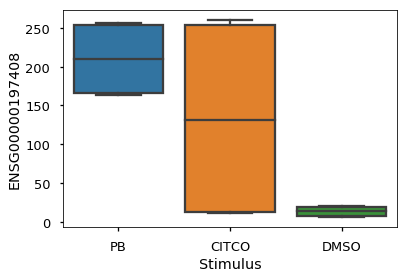

In [11]:
# Let's plot one of these genes across our different cases just to see

sample_meta = pd.read_table("sample_meta.txt", index_col=0, header=0)

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")

gene_name = "CYP2B6"
ens_id = mart_export.index[mart_export['Associated Gene Name'] == gene_name][0]

sns.boxplot(x=sample_meta['Stimulus'], y=tpm_matrix.loc[ens_id])
plt.show()



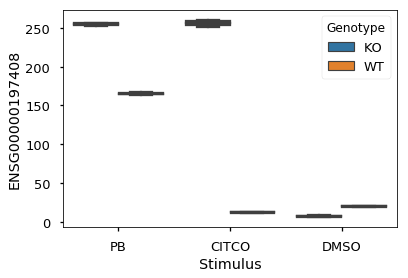

In [12]:
sns.boxplot(x=sample_meta['Stimulus'], y=tpm_matrix.loc[ens_id], hue=sample_meta['Genotype'])
plt.show()

# Section 5: Making Some Plots

## Simple Plots of Quality Metrics

### Histogram

In [13]:
qcdata = pd.read_table("QC_all.txt", index_col=0, header=0)
qcdata = qcdata.T
qcdata

0,PF_BASES,PF_ALIGNED_BASES,CODING_BASES,UTR_BASES,INTRONIC_BASES,INTERGENIC_BASES,IGNORED_READS,CORRECT_STRAND_READS,INCORRECT_STRAND_READS,PCT_CODING_BASES,...,WIDTH_OF_10_PERCENT,WIDTH_OF_20_PERCENT,WIDTH_OF_30_PERCENT,WIDTH_OF_40_PERCENT,WIDTH_OF_50_PERCENT,WIDTH_OF_60_PERCENT,WIDTH_OF_70_PERCENT,WIDTH_OF_80_PERCENT,WIDTH_OF_90_PERCENT,WIDTH_OF_99_PERCENT
SRR2131834,5.279981e+09,4.301523e+09,3.015848e+09,1.285215e+09,0.0,460200.0,0.0,0.0,0.0,0.701112,...,11.0,21.0,31.0,43.0,53.0,65.0,77.0,93.0,159.0,409.0
SRR2131843,4.694375e+09,3.759749e+09,2.534556e+09,1.224674e+09,0.0,519600.0,0.0,0.0,0.0,0.674129,...,11.0,23.0,33.0,45.0,55.0,67.0,81.0,99.0,175.0,441.0
SRR2131833,4.119919e+09,3.367622e+09,2.377481e+09,9.897390e+08,0.0,402200.0,0.0,0.0,0.0,0.705982,...,13.0,25.0,37.0,49.0,63.0,77.0,91.0,111.0,193.0,495.0
SRR2131839,5.261266e+09,4.222497e+09,2.846699e+09,1.375215e+09,0.0,582600.0,0.0,0.0,0.0,0.674174,...,13.0,25.0,37.0,49.0,61.0,73.0,87.0,111.0,193.0,483.0
SRR2131840,5.076936e+09,4.112416e+09,2.815856e+09,1.296053e+09,0.0,506800.0,0.0,0.0,0.0,0.684721,...,13.0,25.0,37.0,49.0,61.0,73.0,89.0,109.0,193.0,489.0
SRR2131837,5.107715e+09,4.194622e+09,2.969338e+09,1.224808e+09,0.0,475400.0,0.0,0.0,0.0,0.707892,...,13.0,25.0,37.0,49.0,63.0,75.0,91.0,111.0,189.0,475.0
SRR2131838,4.359108e+09,3.544435e+09,2.431301e+09,1.112663e+09,0.0,470400.0,0.0,0.0,0.0,0.685949,...,13.0,25.0,39.0,51.0,63.0,77.0,93.0,117.0,207.0,511.0
SRR2131832,3.889281e+09,3.165126e+09,2.221057e+09,9.437226e+08,0.0,346000.0,0.0,0.0,0.0,0.701728,...,13.0,25.0,37.0,49.0,61.0,75.0,89.0,111.0,193.0,489.0
SRR2131842,4.457819e+09,3.554930e+09,2.416908e+09,1.137524e+09,0.0,498400.0,0.0,0.0,0.0,0.679875,...,11.0,23.0,33.0,45.0,55.0,67.0,81.0,97.0,173.0,445.0
SRR2131835,4.866734e+09,3.990826e+09,2.828853e+09,1.161540e+09,0.0,432600.0,0.0,0.0,0.0,0.708839,...,13.0,23.0,35.0,47.0,59.0,71.0,87.0,105.0,183.0,467.0


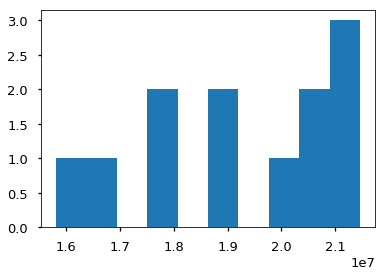

In [14]:
# We can easily plot a histogram of a single quality value
import matplotlib.pyplot as plt
plt.hist(qcdata["READ_PAIRS"])
plt.show()

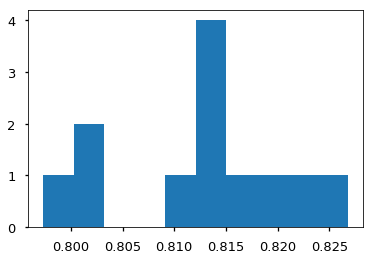

In [15]:
plt.hist(qcdata["PCT_USABLE_BASES"])
plt.show()

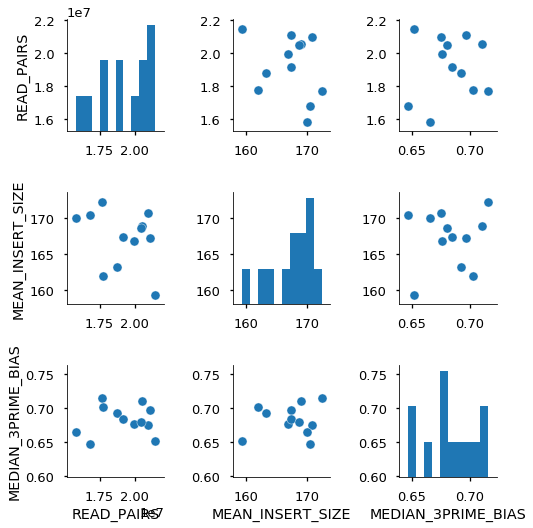

In [16]:
# We can use seaborn to make even more powerful plots
sns.pairplot(qcdata, vars=["READ_PAIRS", "MEAN_INSERT_SIZE", "MEDIAN_3PRIME_BIAS"])
plt.show()

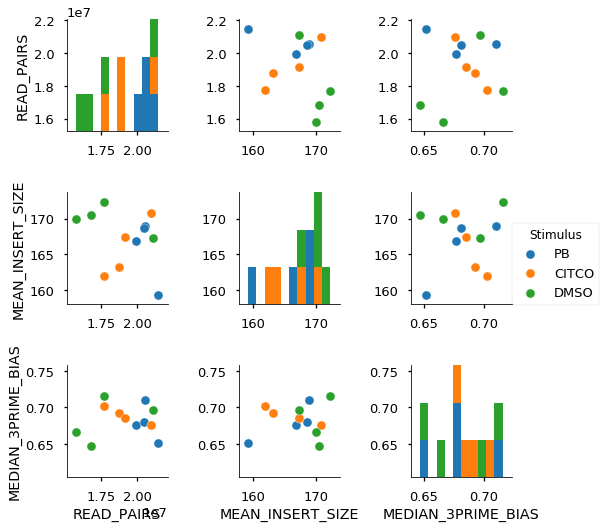

In [17]:
plot_data = qcdata.join(sample_meta)
sns.pairplot(plot_data, vars=["READ_PAIRS", "MEAN_INSERT_SIZE", "MEDIAN_3PRIME_BIAS"], hue="Stimulus")
plt.show()

### Stem Plot

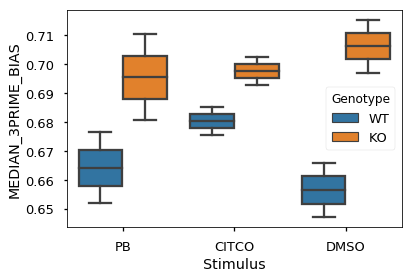

In [18]:
plot_data = qcdata.join(sample_meta)
sns.boxplot(x="Stimulus", y="MEDIAN_3PRIME_BIAS", hue="Genotype", data=plot_data)
plt.show()

## PCA Plot of TPM Values

Principal Component Analysis is one way to reduce your data to a smaller number of dimensions for visualization

In Python, you can get methods for dimensionality reduction from the machine learning package, **scikit-learn**

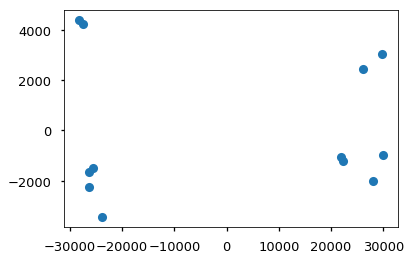

In [19]:
from sklearn.decomposition import PCA 

tpm_matrix = pd.read_table("TPM_Matrix.txt", header=0, index_col=0)

model = PCA(n_components=2)
result = model.fit_transform(tpm_matrix.T)

plt.plot(result[:,0], result[:,1], 'o')
plt.show() # Not very informative

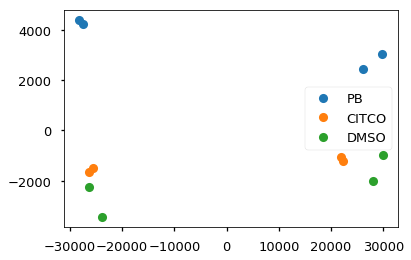

In [20]:
# What if we add some color?

result = pd.DataFrame(result, index=tpm_matrix.columns) # Turn this into a data frame

for stimulus in sample_meta['Stimulus'].unique():
    sub_result = result.loc[sample_meta['Stimulus'] == stimulus]
    plt.plot(sub_result[0], sub_result[1], 'o', label=stimulus)
    
plt.legend(loc='best')
plt.show()

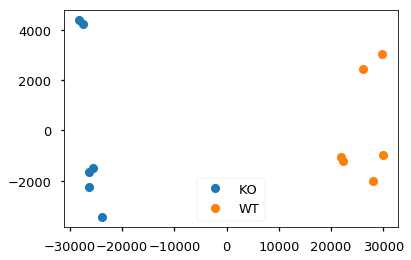

In [21]:
result = pd.DataFrame(result, index=tpm_matrix.columns) # Turn this into a data frame

for genotype in sample_meta['Genotype'].unique():
    sub_result = result.loc[sample_meta['Genotype'] == genotype]
    plt.plot(sub_result[0], sub_result[1], 'o', label=genotype)
    
plt.legend(loc='best')
plt.show()

## Heatmap of DE genes

All the genes would be too much to view in a heatmap
- What about just the DE genes (determined by EBSeq)

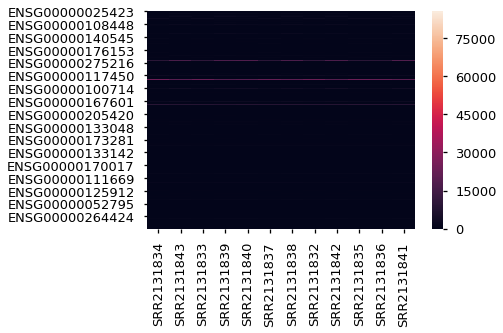

In [22]:
tpm_de = tpm_matrix.loc[ebseq_results.index]

sns.heatmap(tpm_de)
plt.show() # Not so good

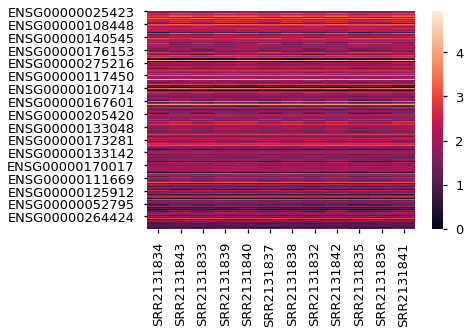

In [23]:
tpm_de = np.log10(tpm_de + 1)
sns.heatmap(tpm_de)
plt.show() # Still kind of a mess...

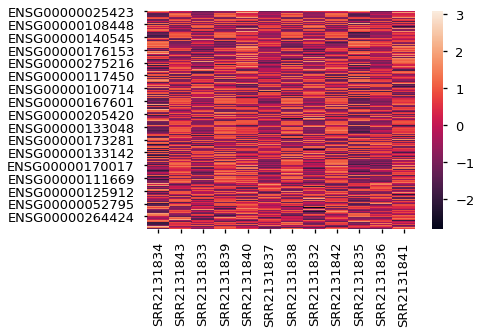

In [24]:
# What if we z-normalize the rows (genes)
tpm_de_norm = tpm_de.subtract( tpm_de.mean(axis="columns"), axis="index")
tpm_de_norm = tpm_de_norm.divide( tpm_de.std(axis="columns"), axis="index")

sns.heatmap(tpm_de_norm)
plt.show()

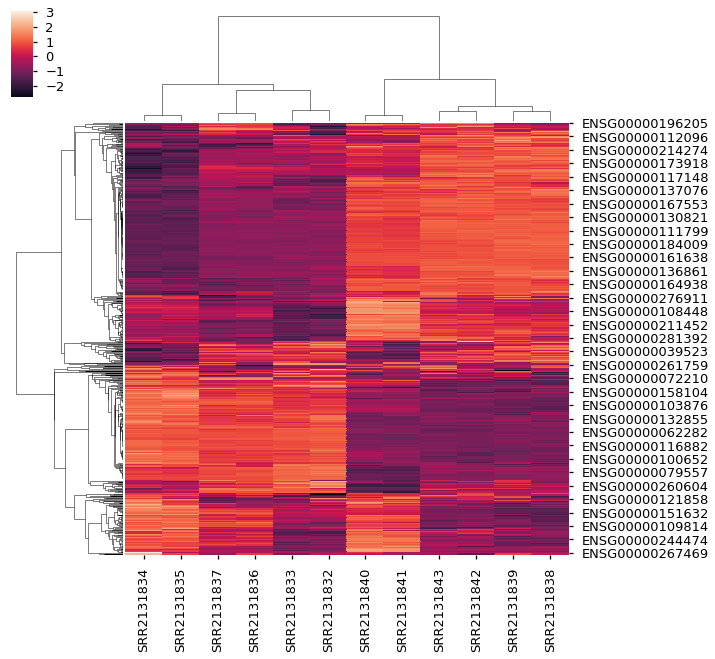

In [25]:
sns.clustermap(tpm_de_norm, metric="cosine")
plt.show() # Now we're starting to see something!

In [26]:
# Lets fix the axes
new_columns = []
for sample_name in tpm_de_norm.columns:
    new_column = sample_meta.loc[sample_name, "Genotype"] + " " + sample_meta.loc[sample_name, 'Stimulus']
    new_columns.append(new_column)
    
tpm_de_norm.columns = new_columns

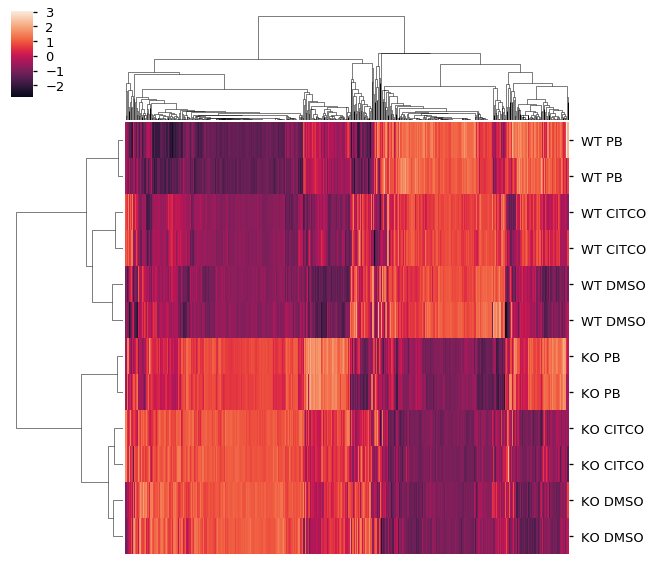

In [27]:
cm = sns.clustermap(tpm_de_norm.T, metric="cosine")
plt.sca(cm.ax_heatmap)
plt.yticks(rotation=0)
plt.xticks([])
plt.show()

# Section 6: Running An Enrichment Analysis

## What is enrichment analysis?

It's a principled way to describe a set of genes.

We can't just say "eh, it looks like there's a lot of lipid metabolism genes in there"

We wan't to do a statistical test 
- "Are there **more** lipid metabolism genes than if I picked genes randomly"

## Running enrichment analysis on our data

The fastest way to run an enrichment analysis on gene sets is to take advantage of some of the many web tools out there.

For most of these, we just need to load our genes names into the clipboard, so we can paste into the website

In [28]:
# Get our differential gene names:

de_gene_info = mart_export.loc[tpm_de_norm.index] # Get just the rows that correspond with differential genes
de_gene_names = de_gene_info['Associated Gene Name']
de_gene_names.to_clipboard(index=False)

# You could also save to excel and just copy/paste from there
# de_gene_info.to_excel("de_genes.xlsx")

**Demo: [GO Consortium](http://geneontology.org/)**

**Demo: [Enrichr](http://amp.pharm.mssm.edu/Enrichr/)**

# Section 7: IGV Demo

IGV is another tool by the Broad Institute (they made Picard too)

Can download [here](https://www.broadinstitute.org/igv/download)

Here I'll do a short demo showing how you can use IGV to visualize individual read alignments


**Demo: IGV**